## Demonstrating Mixture Models
Liberally adapted from **Antonino Ingargiola**'s [github page](https://github.com/tritemio).

### Need for mixture models
We first demonstrate the need for a mixture model over a single model using a simple one dimensional example. Note that fitting a single Gaussian works well if the observed data "follows" that assumption. However, if the data has two (or more modes), using a single Gaussian does not work. 

In [89]:
import numpy as np
import scipy.stats as st
from scipy.stats import norm,bernoulli
from scipy.optimize import minimize, show_options
from sklearn import mixture
import matplotlib.pyplot as plt
import csv
import math
%matplotlib inline

#### Sampling from a mixture model

In [5]:
# generate data again
N = 1000
pi = 0.5
mu1 = 0
sigma1 = 0.08
mu2 = 0.6
sigma2 = 0.08
samples = []
for i in range(N):
    s = bernoulli.rvs(pi,size=1)
    if s == 1:
        v = norm(mu1, sigma1).rvs(1)
    else:
        v = norm(mu2, sigma2).rvs(1)
    samples.append(v[0])
    

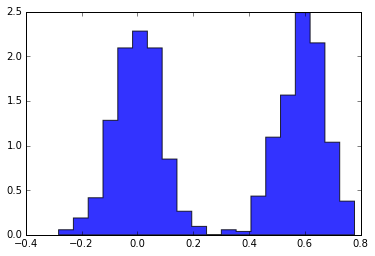

In [6]:
plt.hist(np.array(samples), bins=20,normed=True,histtype='stepfilled',alpha=0.8);

#### Learning parameters for a distribution using MLE

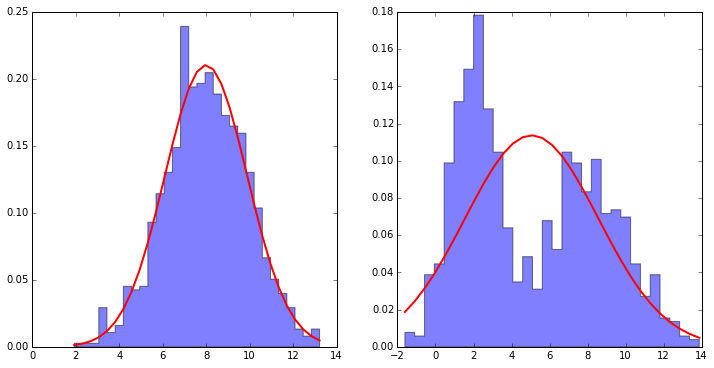

In [7]:
# first load two data sets
single = []
with open('../data/single.dat') as f:
    for line in f:
        single.append(float(line.strip()))
s = np.array(single)
double = []
with open('../data/double.dat') as f:
    for line in f:
        double.append(float(line.strip()))
d = np.array(double)

# plot the empirical distribution and the fitted single Gaussians
fig = plt.figure(num=None, figsize=(12, 6), dpi=96, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,2,1)
cnt,bins,ignored = ax.hist(s,30,normed=True,histtype='stepfilled',alpha=0.5)
mu, sigma = norm.fit(single)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')

ax = fig.add_subplot(1,2,2)
cnt,bins,ignored = ax.hist(d,30,normed=True, histtype='stepfilled',alpha=0.5)
mu, sigma = norm.fit(double)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')


The model for this sample is the linear combination of two Gaussian PDF:

$$p(x|\theta) = \frac{\pi_1}{\sigma_1\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right\} +
\frac{\pi_2}{\sigma_2\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right\}$$

where $\theta = [\mu_1, \sigma_1, \mu_2, \sigma_2, \pi_1]$. 
Note that $\pi_2$ is not included in $\theta$ since $\pi_2 = 1-\pi_1$.



In python we can define $f(x|\theta)$ using `normpdf()` implemented by *Numpy*: 

In [8]:
def pdf_model(x, theta):
    mu1, sig1, mu2, sig2, pi_1 = theta
    return pi_1*norm.pdf(x, mu1, sig1) + (1-pi_1)*norm.pdf(x, mu2, sig2)

##Maximum Likelihood: direct maximization
>We first see how to estimate parameters for the mixture using a direct maxmization of the log likelihood.

Given a sample $X = \{x_i\}$ of size $N$ extracted from the mixture distribution, the likelihood function is

$$\mathcal{L(\theta,X)} = \prod_i p(x_i|\theta)$$

and the log-likelihood function is:

$$\ln \mathcal{L(\theta,X)} = \sum_i \ln p(x_i|\theta)$$

Now, since $p(\cdot)$ is the sum of two terms, the term $\log p(x_i|\theta)$ can't be simplified (it's the log of a sum). 
So for each $x_i$ we must compute the log of the sum of two exponetial. 
It's clear that not only the computation will be slow but also the numerical errors will be amplified.
Moreover, often the likelihood function has local maxima other than the global one
(in other terms the function is not convex).

In python the log-likelihood function can be defined as:

In [9]:
def log_likelihood_two_1d_gauss(theta, sample):
    return -np.log(pdf_model(sample, theta)).sum()

We now try to minimize using several options in the numpy.scipy.optimize function.

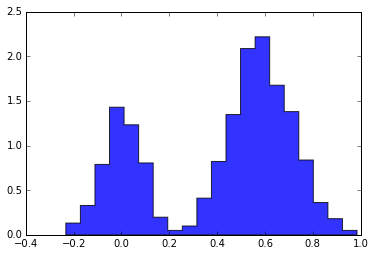

In [10]:
# generate data again
N = 1000
a = 0.3
s1 =  np.random.normal(0, 0.08, size=N*a)
s2 = np.random.normal(0.6,0.12, size=N*(1-a))
d = np.concatenate([s1,s2])
plt.hist(d, bins=20,normed=True,histtype='stepfilled',alpha=0.8);

In [11]:
# Initial guess
theta0 = np.array([-0.2,0.2,0.8,0.2,0.5])

In [11]:
# Minimization 1
res = minimize(log_likelihood_two_1d_gauss, x0=theta0, args=(d,), method='BFGS')
#res # NOT CONVERGED
res

/Users/chandola/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from IPython.kernel.zmq import kernelapp as app


      fun: nan
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([ nan,  nan,  nan,  nan,  nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 294
      nit: 1
     njev: 42
   status: 2
  success: False
        x: array([ 1682237.846875 ,   603061.85625  , -3395585.278125 ,
        1010555.9734375,  -777472.96875  ])

In [12]:
# Minimization 2
res = minimize(log_likelihood_two_1d_gauss, x0=theta0, args=(d,), method='powell',
        options=dict(maxiter=10e3, maxfev=2e4))
res # NOT CONVERGED

/Users/chandola/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from IPython.kernel.zmq import kernelapp as app
/Users/chandola/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:2139: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(wlim - xc) >= 0.0:
/Users/chandola/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:2118: RuntimeWarning: overflow encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/chandola/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:2112: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = (xb - xc) * (fb - fa)
/Users/chandola/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:2118: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/chandola/anaconda/lib/python2.7/site-packages/scipy/optimiz

   direc: array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])
     fun: nan
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20020
     nit: 303
  status: 1
 success: False
       x: array([ nan,  nan,  nan,  nan,  nan])

In [13]:
# Minimization 3
res = minimize(log_likelihood_two_1d_gauss, x0=theta0, args=(d,), method='Nelder-Mead',
        options=dict(maxiter=10e3, maxfev=2e4))
res

 final_simplex: (array([[-0.00133681,  0.07655746,  0.60353552,  0.12389526,  0.2986471 ],
       [-0.00132983,  0.07655716,  0.60354033,  0.1238796 ,  0.29873256],
       [-0.00132241,  0.07655057,  0.60351552,  0.1238867 ,  0.29866886],
       [-0.00133964,  0.0765497 ,  0.60354526,  0.12391668,  0.29864191],
       [-0.00133298,  0.07655073,  0.60355179,  0.12388949,  0.2985843 ],
       [-0.00130411,  0.07656408,  0.60352003,  0.12388735,  0.29865527]]), array([-208.19598952, -208.19598527, -208.19598083, -208.19597756,
       -208.19597745, -208.19597644]))
           fun: -208.19598951750652
       message: 'Optimization terminated successfully.'
          nfev: 446
           nit: 280
        status: 0
       success: True
             x: array([-0.00133681,  0.07655746,  0.60353552,  0.12389526,  0.2986471 ])

In [14]:
# Minimization 4
res = minimize(log_likelihood_two_1d_gauss, x0=theta0, args=(d,), method='L-BFGS-B',
    bounds=[(-0.5,2),(0.01,0.5),(-0.5,2),(0.01,0.5),(0.01,0.99)])
res

/Users/chandola/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app
/Users/chandola/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:562: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: nan
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-479.55391551,  832.89410213, -342.87567701,  430.81221577,
        200.66558193])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 366
      nit: 8
   status: 2
  success: False
        x: array([ 0.59480438,  0.13051792, -0.15611314,  0.46629206,  0.70280864])

## Expectation Maximization
Now we will learn the parameters using the EM procedure for learning Gaussian mixtures.

Starting from the PDF $p_1()$ and $p_2()$ of the single components:

$$p_1(x|\theta) = \frac{1}{\sigma_1\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right\}
\qquad
p_2(x|\theta) = \frac{1}{\sigma_2\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right\}
$$

the mixture PDF is:

$$ p(x|\theta) = \pi_1 p(x|\theta_1) + \pi_2 p(x|\theta_2) $$

If we know (or guess initially) the parameters $\theta$, we can compute for each sample 
and each component the **responsibility function** defined as:
    
$$\gamma(i, k) =  \frac{\pi_kp(x_i|\theta_k)}{p(x_i|\theta)}$$

and starting from the "effective" number of samples for each category ($N_k$) we can compute the 
"new" estimation of parameters:
    
$$N_k = \sum_{i=1}^N \gamma(i, k)
\qquad\qquad
k=1,2
\quad
({\rm note\;that} \quad N_1 + N_2 = N)
$$

$$\mu_k^{new} = \frac{1}{N_k}\sum_{i=1}^N \gamma(i, k) \cdot s_i$$

$$\sigma_k^{2\,new} = \frac{1}{N_k}\sum_{i=1}^N \gamma(i, k) \cdot (s_i - \mu_k^{new})^2$$

$$\pi_k^{new} = \frac{N_k}{N}$$

Now we just loop 

 1. recompute $\gamma(i, k)$
 2. estimate updated parameters

until convergence.

In [12]:
s = d
max_iter = 100

# Initial guess of parameters and initializations
theta0 = np.array([-0.2,0.2,0.8,0.2,0.5])
mu1, sig1, mu2, sig2, pi_1 = theta0
mu = np.array([mu1, mu2])
sig = np.array([sig1, sig2])
pi_ = np.array([pi_1, 1-pi_1])

gamma = np.zeros((2, s.size))
N_ = np.zeros(2)
theta_new = theta0

# EM loop
counter = 0
converged = False
while not converged:
    # Compute the responsibility func. and new parameters
    for k in [0,1]:
        # E Step
        gamma[k,:] = pi_[k]*norm.pdf(s, mu[k], sig[k])/pdf_model(s, theta_new)
        # M Step
        N_[k] = 1.*gamma[k].sum()
        mu[k] = sum(gamma[k]*s)/N_[k]
        sig[k] = np.sqrt( sum(gamma[k]*(s-mu[k])**2)/N_[k] )
        pi_[k] = N_[k]/s.size
    theta_new = [mu[0], sig[0], mu[1], sig[1], pi_[0]]
    assert abs(N_.sum() - N)/float(N) < 1e-6 
    assert abs(pi_.sum() - 1) < 1e-6
    
    # Convergence check
    counter += 1
    converged = counter >= max_iter

In [13]:
# print learnt parameters
print "Means:   %6.2f  %6.2f" % (theta_new[0], theta_new[2])
print "Std dev: %6.2f  %6.2f" % (theta_new[1], theta_new[3])
print "Mix (1): %6.2f " % theta_new[4]

Means:     0.00    0.59
Std dev:   0.08    0.13
Mix (1):   0.30 


In [14]:
def sim_two_gauss_mix(theta, N=1000): 
    x1 =  np.random.normal(theta[0], theta[1], size=N*theta[4])
    x2 = np.random.normal(theta[2], theta[3], size=N*(1-theta[4]))
    x = np.concatenate([x1,x2])
    return x

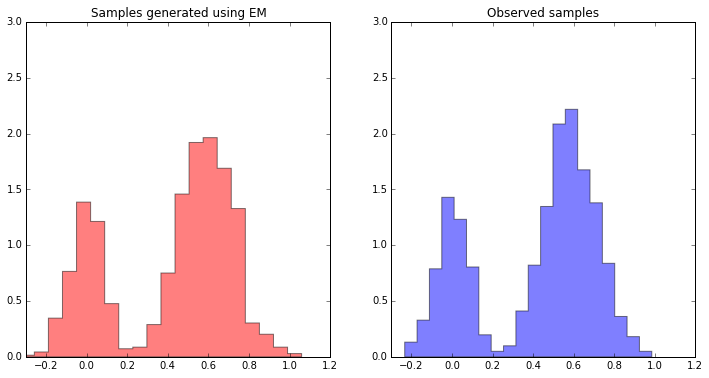

In [15]:
# draw samples from the learnt model and compare with the actual data
samples = sim_two_gauss_mix(theta_new)
fig = plt.figure(num=None, figsize=(12, 6), dpi=96, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,2,1)
ax.set_xlim((-.3,1.2))
ax.set_ylim((0,3))

ax.hist(samples, bins=20,normed=True,histtype='stepfilled',alpha=0.5,color='r')
t1 = plt.title('Samples generated using EM')
ax = fig.add_subplot(1,2,2)
ax.set_xlim((-.3,1.2))
ax.set_ylim((0,3))
ax.hist(d, bins=20,normed=True,histtype='stepfilled',alpha=0.5)
t2 = plt.title('Observed samples')

### Animated view of 2d mixture learning

In [29]:
def pltcontour(mu,sigma,ax,c):
    x1,x2 = np.mgrid[-3:3:.1, -3:3:.1]
    pos = np.dstack((x1, x2))
    rv = st.multivariate_normal(mu,sigma)
    levels = np.arange(-1.2, 1.6, 0.2)
    cn = ax.contour(x1, x2, rv.pdf(pos),1,colors=c,linewidth=16)
    return cn
    

In [3]:
# load old faithful data
data = []
with open ('../data/oldfaithful.csv','r') as f:
    fr = csv.reader(f)
    for row in fr:
        data.append((float(row[1]),float(row[2])))
data = np.array(data)
data = st.zscore(data)


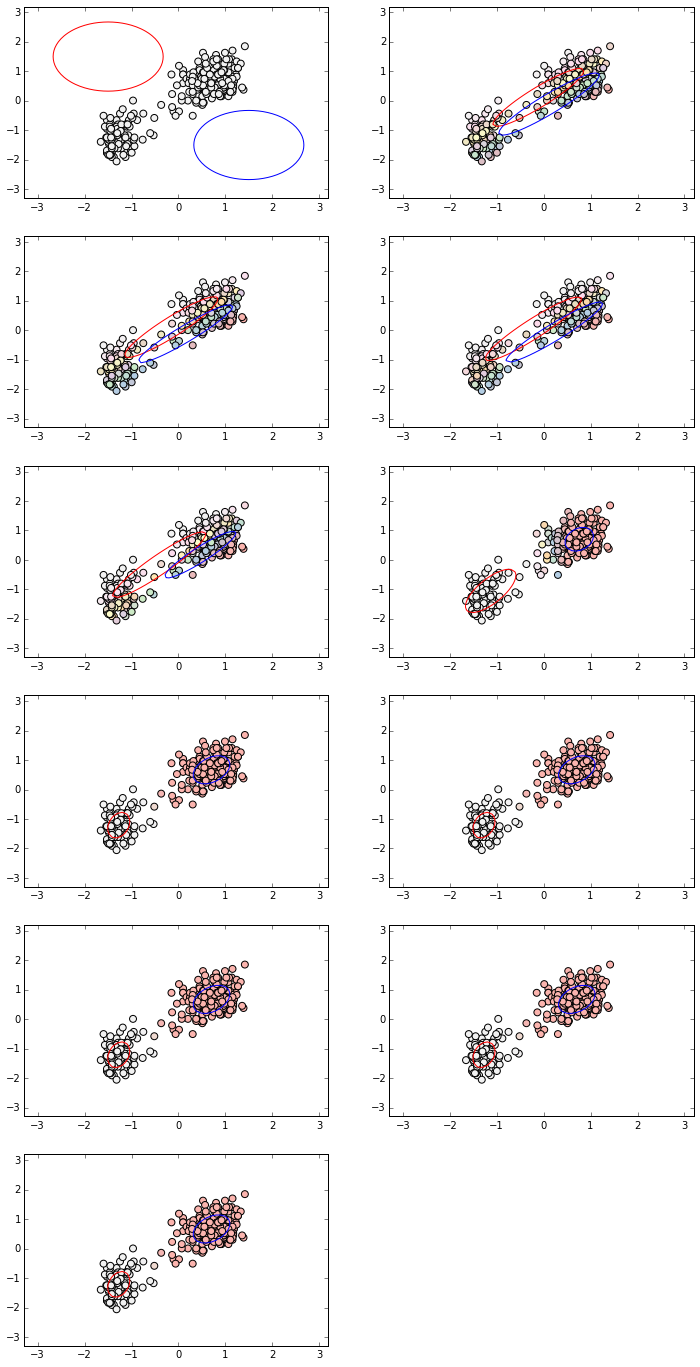

In [20]:
# initialize
mu1 = np.array([-1.5,1.5])
mu2 = np.array([1.5,-1.5])
sig1 = np.eye(2)
sig2 = np.eye(2)
pi = np.array([0.5,0.5])
mu = [mu1, mu2]
sig = [sig1, sig2]

# plot initial
fig = plt.figure(figsize=[12,24])
#ax = fig.gca()
cnt = 1
ax = plt.subplot(6,2,cnt)
colors = -1*np.ones([data.shape[0],])

ax.scatter(data[:,0],data[:,1],c=colors,s=48,cmap=plt.colormaps()[29])
# plot contours
pltcontour(mu[0],sig[0],ax,'r')
pltcontour(mu[1],sig[1],ax,'b')
# RUN EM

max_iter = 100
N_ = np.zeros(2)

## save data for animations
gammas = []
mus = []
sigs = []
# EM loop
for iters in range(max_iter):
    
    # E Step
    gamma = np.zeros([data.shape[0],2])
    rv0 = st.multivariate_normal(mu[0],sig[0])
    rv1 = st.multivariate_normal(mu[1],sig[1])

    pdfs1 = rv0.pdf(data)
    pdfs2 = rv1.pdf(data)
    den = pdfs1*pi[0] + pdfs2*pi[1]
    gamma[:,0] = (pdfs1*pi[0])/den
    gamma[:,1] = (pdfs2*pi[1])/den
    
    # M Step
    mu = []
    pi = np.sum(gamma,axis=0)/data.shape[0]
    N_ = 1.*np.sum(gamma,axis=0)
    mu.append(sum(np.tile(gamma[:,0:1],[1,2])*data)/N_[0])
    mu.append(sum(np.tile(gamma[:,1:2],[1,2])*data)/N_[1])

    s0 = np.zeros(sig[0].shape)
    s1 = np.zeros(sig[1].shape)
    
    for i in range(data.shape[0]):
        dm0 = (data[i,:] - mu[0])
        dm0 = dm0[:,np.newaxis]
        s0 = s0 + gamma[i,0]*np.dot(dm0,np.transpose(dm0))
        dm1 = (data[i,:] - mu[1])
        dm1 = dm1[:,np.newaxis]
        s1 = s1 + gamma[i,1]*np.dot(dm1,np.transpose(dm1))
    sig = []
    sig.append(s0/N_[0])
    sig.append(s1/N_[1])
    
    # plot every 10th iteration
    
    if iters%10 == 0:
        colors = -1*gamma[:,0] + 1*gamma[:,1]
        cnt = cnt + 1
        ax = plt.subplot(6,2,cnt)
        scat = ax.scatter(data[:,0],data[:,1],c=colors,s=48,cmap=plt.colormaps()[29])
        # plot contours
        pltcontour(mu[0],sig[0],ax,'r')
        pltcontour(mu[1],sig[1],ax,'b')

    ## save data for animations
    gammas.append(gamma)
    sigs.append(sig)
    mus.append(mu)



In [23]:
from tempfile import NamedTemporaryFile
from matplotlib import animation
from IPython.display import HTML

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [103]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=[10,8])
ax = plt.axes(xlim=(-4, 4), ylim=(-4, 4))
scat = ax.scatter(data[:,0],data[:,1],s=48,alpha=0.6)
# animation function.  This is called sequentially
def init():
    return scat

def animate(i,gammas,mus,sigs):
    gamma = gammas[i]
    mu = mus[i]
    sig = sigs[i]
    cvals = -1*gamma[:,0] + 1*gamma[:,1]
    colors = [floatRgb(c,-1,1) for c in cvals]
    scat.set_facecolors(colors)
    scat.set_cmap(plt.colormaps()[29])
    ax = scat.get_axes()
    return scat

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,init_func=init,fargs=(gammas,mus,sigs),
                               frames=len(gammas), interval=100, blit=True,repeat=True)

# call our new function to display the animation
display_animation(anim)

In [93]:
def floatRgb(v, cmin, cmax):
       """
       Return a tuple of floats between 0 and 1 for the red, green and
       blue amplitudes.
       """

       try:
              # normalize to [0,1]
              x = float(v-cmin)/float(cmax-cmin)
       except:
              # cmax = cmin
              x = 0.5
        
       blue = min((max((4*(0.75-x), 0.)), 1.))
       red  = min((max((4*(x-0.25), 0.)), 1.))
       green= min((max((4*math.fabs(x-0.5)-1., 0.)), 1.))
       return (red, green, blue)